# About

The Iraq-Oncology Teaching Hospital/National Center for Cancer Diseases (IQ-OTH/NCCD) lung cancer dataset was collected in the above-mentioned specialist hospitals over a period of three months in fall 2019. It includes CT scans of patients diagnosed with lung cancer in different stages, as well as healthy subjects. IQ-OTH/NCCD slides were marked by oncologists and radiologists in these two centers. The dataset contains a total of 1190 images representing CT scan slices of 110 cases (see Figure 1). These cases are grouped into three classes: normal, benign, and malignant. of these, 40 cases are diagnosed as malignant; 15 cases diagnosed with benign, and 55 cases classified as normal cases. The CT scans were originally collected in DICOM format. The scanner used is SOMATOM from Siemens. CT protocol includes: 120 kV, slice thickness of 1 mm, with window width ranging from 350 to 1200 HU a and window center from 50 to 600 were used for reading. with breath-hold at full inspiration. All images were de-identified before performing analysis. Written consent was waived by the oversight review board. The study was approved by the institutional review board of participating medical centers. Each scan contains several slices. The number of these slices range from 80 to 200 slices, each of them represents an image of the human chest with different sides and angles. The 110 cases vary in gender, age, educational attainment, area of residence, and living status. Some of them are employees of the Iraqi ministries of Transport and Oil, others are farmers and gainers. Most of them come from places in the middle region of Iraq, particularly, the provinces of Baghdad, Wasit, Diyala, Salahuddin, and Babylon.


We have merged the following dataset entitled Chest CT-Scan images Dataset (https://www.kaggle.com/datasets/mohamedhanyyy/chest-ctscan-images)into the above dataset to increase the number of images used for training. The tool https://github.com/OmdenaAI/myanmar-chapter-chest-x-rays/blob/cancer-detection-model-tph/src/visualizations/cancer-detection-model/merge_datasets.ipynb was used to merge the two datasets. The Chest CT-Scan images dataset classified Adenocarcinoma, Large cell carcinoma, Squamous cell carcinoma and normal. All the non-normal images are treated as malignant in the merged dataset.

# Acknowledgements

This notebook is based on https://www.kaggle.com/code/adityamahimkar/lung-cancer-prediction-on-image-data by ADITYA MAHIMKAR

## Link to research paper

https://www.researchgate.net/publication/355647879_Computer-Aided_Detection_of_Lung_Cancer_from_CT-scan_Images_with_Visual_Insights_using_Deep_Convolutional_Neural_Network

### Accuracy of tested models from paper

TBD anyone know how to left justify a table?

|Architecture |Loss Non-Weighting |Loss Weighting |Accuracy Non-Weighting |Accuracy Weighting
-----|-----|-----|-----|-----
CNN|38.26|34.49|84.82|90.1
ResNet50V2|35.02|22.80|95.54|98.2
Xception|10.02|10.20|98.21|99.1

# Import Packages

In [2]:
%config Completer.use_jedi = False
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import seaborn as sns
import cv2
import random
import os
import imageio
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from collections import Counter

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, RepeatedStratifiedKFold
from imblearn.over_sampling import SMOTE

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from keras.applications import resnet
from keras.applications.resnet import ResNet50
from keras.preprocessing.image import ImageDataGenerator

In [4]:
# If you are running from colab
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')
    print('Running on CoLab')
    directory = r'/content/drive/Shareddrives/cancer-detection-model/MERGED The IQ-OTHNCCD lung cancer dataset'
else:
    # If you want to run local
    print('Not running on CoLab')
    directory = r'../../data/cancer-detection-model/MERGED The IQ-OTHNCCD lung cancer dataset'

categories = ['Bengin cases', 'Malignant cases', 'Normal cases']

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Running on CoLab


# Useful functions

In [5]:
def output_countplot(df, x, order=None, hue=None, figsize=None, title=None):
    '''Output a customized nice looking standardized countplot
        :df: DataFrame to use
        :x: The x axis variable to use in the plot
        :order: The y axis variable to use in the plot default is None
        :hue: The hue variable to use in the plot default is None
        :figsize: The figure size tuple to use in the plot default is None
        :title: The title to use default is Countplot: for {}
    '''

    if (title is None):
        title = 'Countplot for {}'.format(x)

        if (hue is not None):
            title += ' with hue of {}'.format(hue)

    # Use default figsize if not provided
    if (figsize is None):
        figsize=(15,5);

    plt.figure(figsize=figsize);

    plt.xticks(rotation=45);
    plt.rcParams["figure.figsize"] = [7.0, 3.5]
    plt.rcParams["figure.autolayout"] = True

    # Ouput count plot
    ax = sns.countplot(data=df,x=x,order=order,hue=hue);

    # output the amounts on top of the bars
    for p in ax.patches:
        x = p.get_x() + p.get_width() / 2
        y = p.get_y() + p.get_height() + (p.get_height()*0.01)

        value = '{:.1f}'.format(p.get_height())

        if (pd.isna(x) or pd.isna(y) or pd.isna(value)):
            continue

        ax.text(x, y, value, ha="center")

    plt.title(title);
    plt.show();


def output_image_histogram(img, title):
    '''Output image display and associated hostogram
        :img:Image to display
        :title: title to output
    '''
    num_columns = 2
    fig, (ax1, ax2) = plt.subplots(1, num_columns)
    fig.suptitle(title)

    ax1.imshow(img)
    ax2.hist(img.ravel(),256,[0,256])

def process_normalize(directory, categories, image_size):
    '''Process and normalize images
        :directory: Root directory of images
        :categories: Categories of diagnosis
        :image_size: Target image size to resize
    '''
    data = []
    X, y = [], []

    for category_index, category in enumerate(categories):
        path = os.path.join(directory, category)

        # Iterate through images and capture image data, resize it and capture category index
        for file in os.listdir(path):
            filepath = os.path.join(path, file)
            img = cv2.imread(filepath, 0)

            # resize the image
            img = cv2.resize(img, (image_size, image_size))
            data.append([img, category_index])

    random.shuffle(data)

    # Split out the image and category data
    image_data, category_data = map(list, zip(*data))
    # Convert the category index into a vector ala [0, 1, 0] because we do
    # not want to imply in the model that index 0 is not as good as 1 and 2 is better than 1 etc.
    y = keras.utils.to_categorical(category_data)

    X = np.array(image_data).reshape(-1, image_size, image_size, 1)

    print('X counts:', X.shape)
    print('y counts:', y.shape)

    # Normalize image values to be between the values of 0 and 1
    X = X / 255.0
    y = np.array(y)

    return X, y

# Data Analysis

In [6]:
size_data = []
file_data = []
category_data = []
for category_index, category in enumerate(categories):
    path = os.path.join(directory, category)

    for file in os.listdir(path):
        category_data.append(category)
        filepath = os.path.join(path, file)
        file_data.append(filepath)
        image_shape = imageio.v3.imread(filepath).shape
        height, width = image_shape[0], image_shape[1]
        size_data.append('{} x {}'.format(height, width))


image_meta_df = pd.DataFrame()
image_meta_df['Filename'] = file_data
image_meta_df['Category'] = category_data
image_meta_df['Size'] = size_data
image_meta_df.head()

,Filename,Category,Size
0,/content/drive/Shareddrives/cancer-detection-m...,Bengin cases,512 x 512
1,/content/drive/Shareddrives/cancer-detection-m...,Bengin cases,512 x 512
2,/content/drive/Shareddrives/cancer-detection-m...,Bengin cases,512 x 512
3,/content/drive/Shareddrives/cancer-detection-m...,Bengin cases,512 x 512
4,/content/drive/Shareddrives/cancer-detection-m...,Bengin cases,512 x 512


In [7]:
image_meta_df.shape

(2097, 3)

- There are 2097 images in our dataset

## Visualizing Categories and Image sizes

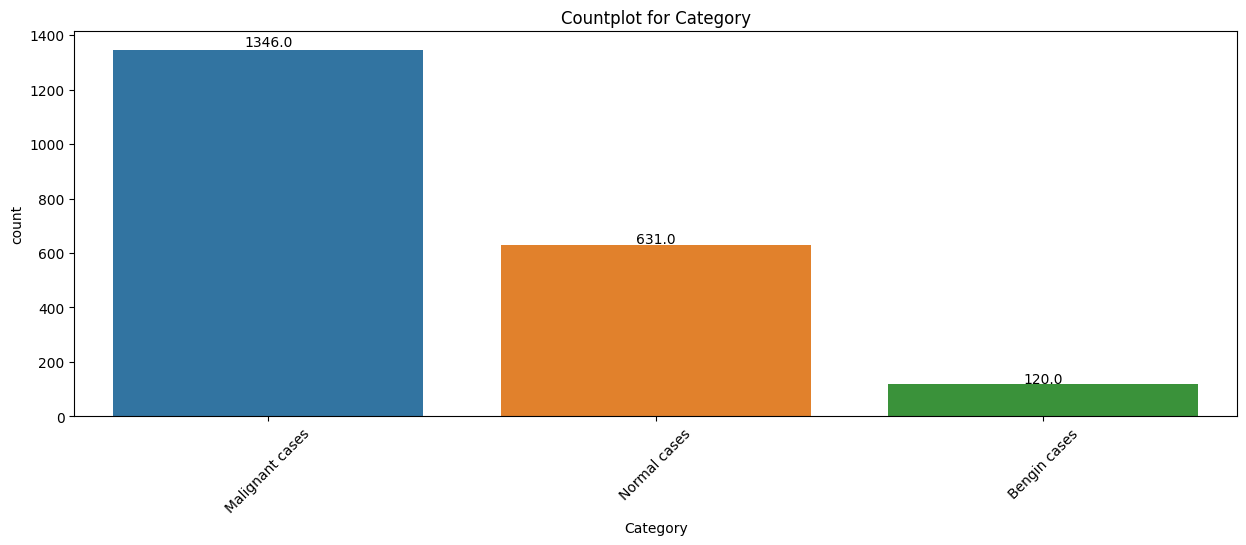

In [8]:
output_countplot(image_meta_df, 'Category', order=image_meta_df['Category'].value_counts().index)

- We can see that the dataset is imbalanced and contains mostly malignant and normal cases.

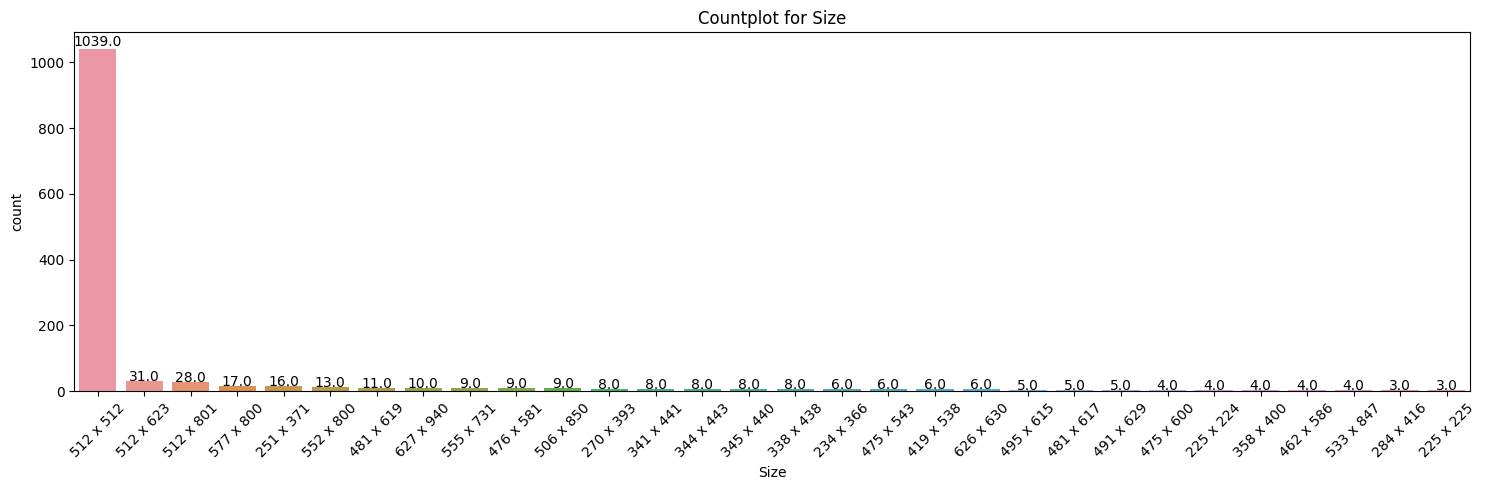

In [9]:
output_countplot(image_meta_df, 'Size', order=image_meta_df['Size'].value_counts().head(30).index)

- The majority of the images are 512 x 512 (over half) hoewever there are quite a few images with odd sizes with counts of five and less.
- The majority of the overall images have 512 for an dimension.
- We can try to resize images to 256x256 and 512x512 and test results.

# Explore example category images and histograms

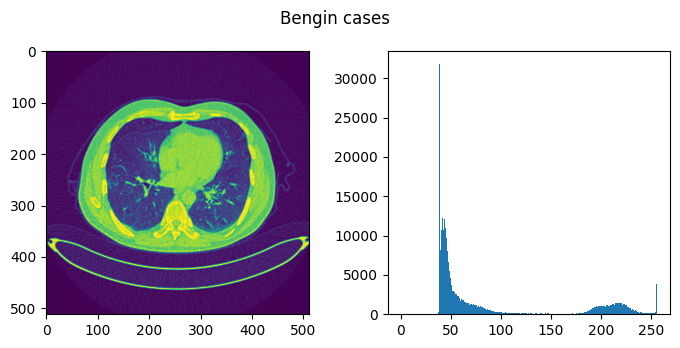

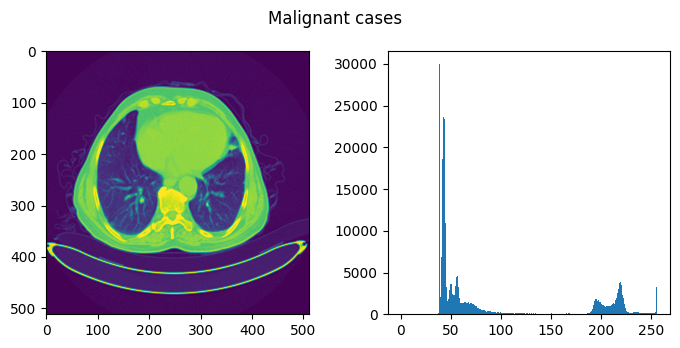

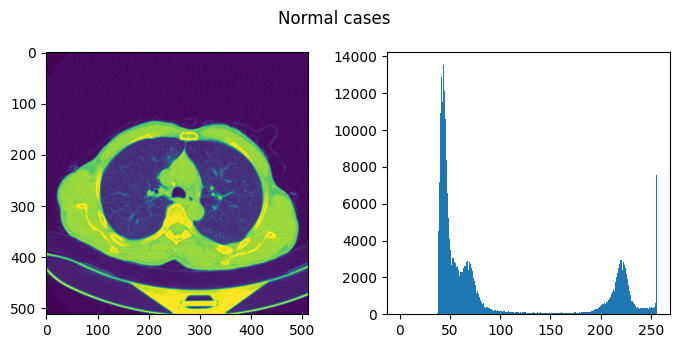

In [10]:
num_columns = 2

for i, category in enumerate(categories):

    path = os.path.join(directory, category)
    file = os.listdir(path)[0]
    filepath = os.path.join(path, file)
    img = cv2.imread(filepath, 0)

    output_image_histogram(img, category)

plt.show()

- Malignant cases look distinctly different from normal and benign
- The histogram for the malignant case has an additional peak in values around 40 that is around 3x higher than the Normal and Benign cases.
- The histograms for Normal and Benign have a similar appearance.

## Let's look at some of the oddly shaped images

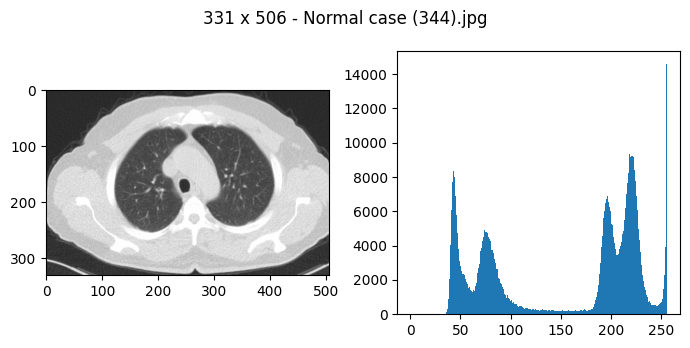

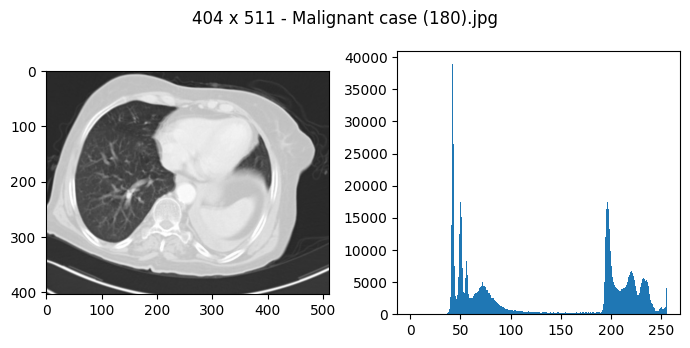

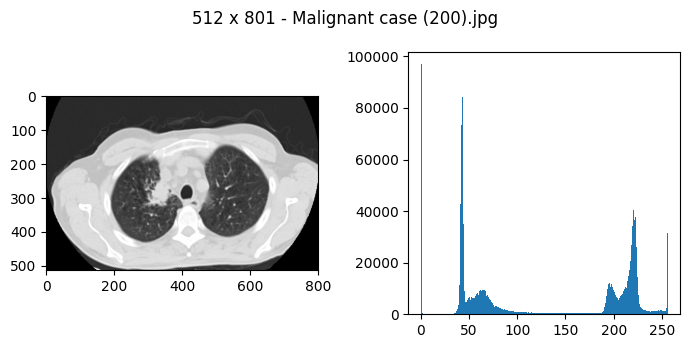

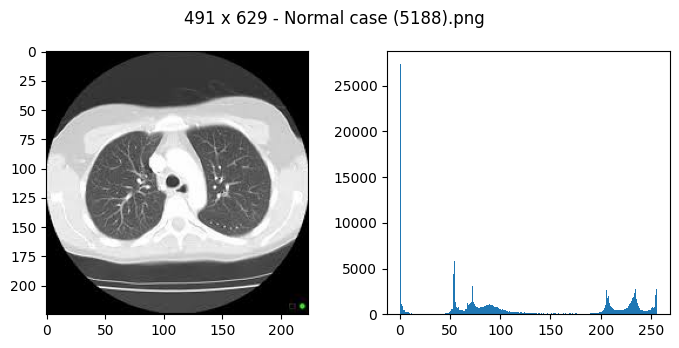

In [16]:
# Build adictionary of oddly sized images
odd_file_dict = {}
odd_file_dict['331 x 506'] = image_meta_df[image_meta_df['Size'] == '331 x 506'].Filename
odd_file_dict['404 x 511'] = image_meta_df[image_meta_df['Size'] == '404 x 511'].Filename
odd_file_dict['512 x 801'] = image_meta_df[image_meta_df['Size'] == '512 x 801'].head(1).Filename
odd_file_dict['225 x 224'] = image_meta_df[image_meta_df['Size'] == '225 x 224'].head(12).Filename

for k, v in odd_file_dict.items():
    filepath = v.iloc[0]
    img = cv2.imread(filepath)
    output_image_histogram(img, '{} - {}'.format(k, os.path.basename(filepath)))

plt.show()

- The oddly shaped images look reasonable.
- Note the two malignant cases show a similar second peak around 40 that the other malignant image showed.

# Preprocess and normalize images and prepare dependent and independent variables

### 256x256 resize and normalization

In [12]:
X_256, y_256 = process_normalize(directory, categories, 256)

X counts: (2097, 256, 256, 1)
y counts: (2097, 3)


### 512x512 resize and normalization

In [13]:
X_512, y_512 = process_normalize(directory, categories, 512)

X counts: (2097, 512, 512, 1)
y counts: (2097, 3)


# Preparing Data

## Train, test and split for the 256x256 dataset

In [14]:
X_train_256, X_valid_256, y_train_256, y_valid_256 = train_test_split(X_256, y_256, random_state=42, stratify=y_256)

print('X train length {}, dimensions {}'.format(len(X_train_256), X_train_256.shape))
print('X valid length {}, dimensions {}'.format(len(X_valid_256), X_valid_256.shape))

X train length 1572, dimensions (1572, 256, 256, 1)
X valid length 525, dimensions (525, 256, 256, 1)


## Train, test and split for the 512x512 dataset

In [15]:
X_train_512, X_valid_512, y_train_512, y_valid_512 = train_test_split(X_512, y_512, random_state=42, stratify=y_512)

print('X train length {}, dimensions {}'.format(len(X_train_512), X_train_512.shape))
print('X valid length {}, dimensions {}'.format(len(X_valid_512), X_valid_512.shape))

X train length 1572, dimensions (1572, 512, 512, 1)
X valid length 525, dimensions (525, 512, 512, 1)
